In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

# Measurement with low detection power
stepping through the following sequence  
* shutter closed 
* shutter open

at low UV detection power (.7mW) and 38 mW UV rotational cooling power.  
Polarization switching for both lasers is on:  
* 1.62 MHz detection laser
* 1.5 MHz rotational cooling laser

In [3]:
fname = "2020_10_9.hdf"
dset_name = "1602262481 low_det_power"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM', 'SDG1032X')

In [4]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

indices no yag fired [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1511, 1577, 1730, 1823]


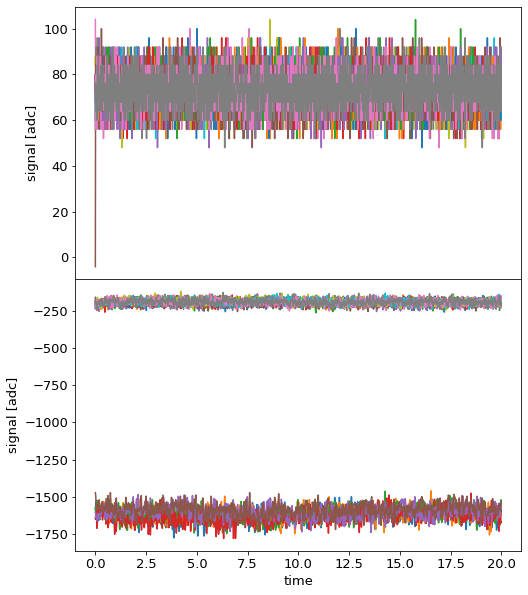

In [43]:
indices_noyag = []
for idx in range(1,len(pxie)+1):
    if pxie[idx][:,0].max() < 200:
        indices_noyag.append(idx)

x = np.linspace(0,1999,2000)/100
fig, axes = plt.subplots(2,1,figsize = (8,10), sharex = True,
                         gridspec_kw={'hspace': 0})
for idx in indices_noyag:
    axes[0].plot(x, pxie[idx][:,0])
    axes[1].plot(x, pxie[idx][:,1])
for ax in axes:
    set_fontsize(ax, 13)
    ax.set_xlabel('time')
    ax.set_ylabel('signal [adc]')
print('indices no yag fired', indices_noyag)

In [6]:
import copy

# combinations
shutter_states = ['open', 'closed']

data_grouped = {'open':[], 'closed':[]}
indices_grouped = copy.deepcopy(data_grouped)

In [8]:
ch = 1
for idx in range(1,len(pxie)+1):
    attrs = pxie_attrs[idx]
    if attrs['ShutterControl SetVoltage'] == '0':
        indices_grouped['closed'].append(idx)
        data_grouped['closed'].append(pxie[idx][:,ch])
    elif attrs['ShutterControl SetVoltage'] == '5':
        indices_grouped['open'].append(idx)
        data_grouped['open'].append(pxie[idx][:,ch])

integral ratio : 2.51918 +/- 0.25708


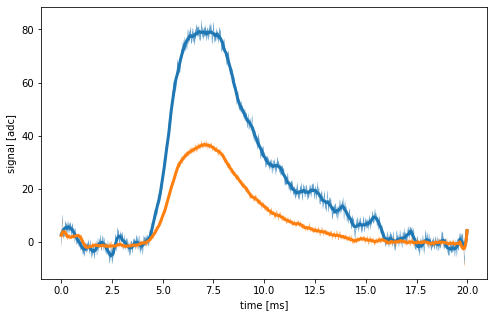

In [24]:
from scipy.signal import savgol_filter

yo = np.mean(data_grouped['open'], axis = 0)
yc = np.mean(data_grouped['closed'], axis = 0)
yo -= np.mean(yo[:300])
yc -= np.mean(yc[:300])

lo = len(data_grouped['open'])
lc = len(data_grouped['closed'])

syo = np.std(data_grouped['open'], axis = 0)
syo /= np.sqrt(lo)
syc = np.std(data_grouped['closed'], axis = 0)
syc /= np.sqrt(lc)

x = np.linspace(0,1999,2000)/100

trapzo = np.trapz(-yo)
trapzc = np.trapz(-yc)
trapz_error = (trapzo/trapzc)*np.sqrt((np.sum(syo)/trapzo)**2 + (np.sum(syc)/trapzc)**2)


fig, ax = plt.subplots(figsize = (8,5))

ax.fill_between(x, -yo-syo, -yo+syo, alpha = .7)
ax.fill_between(x, -yc-syc, -yc+syc, alpha = .7)
ax.plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
ax.plot(x, -savgol_filter(yc, 51, 3), lw = 3, label= 'rc off')
ax.set_xlabel('time [ms]')
ax.set_ylabel('signal [adc]')

print(f'integral ratio : {np.trapz(-yo)/np.trapz(-yc):.5f} +/- {trapz_error:.5f}')